<a href="https://colab.research.google.com/github/kimheeseo/2022_AI_SW_Programmingstudy/blob/main/Pytorch_RNN_LSTM_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

print(torch.__version__)

1.9.0+cu102


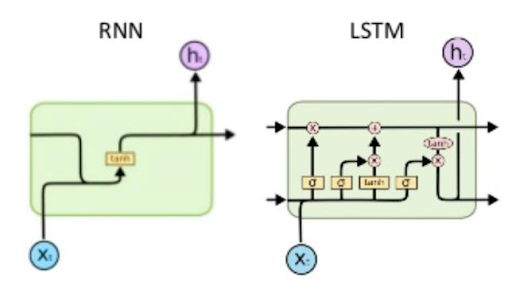

In [ ]:
from PIL import Image
from IPython.display import Image

image = Image(filename='rnn lstm.png')
display(image)

1. RNN in pytorch        
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

2. LSTM in pytorch           
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
# RNN 예시
rnn = nn.RNN(3, 3, batch_first=True)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # batch의 크기가 5
print('inputs : ', inputs)
print('input의 크기', len(inputs))
# initialize the hidden state.
hidden = (torch.randn(1, 1, 3))
for i in inputs:
    # 한 스텝에서 하나의 sequence를 입력으로 
    # 각 스텝이 끝날 때마다 hidden 값은 연결됨
    print(i.view(1, 1, -1))
    out, hidden = rnn(i.view(1, 1, -1), hidden)
    
print('out: ', out)
print('out shape: ', out.shape)
print('hidden: ', hidden)
print('hidden shape: ', hidden.shape)

inputs :  [tensor([[-9.9443e-01, -4.8892e-01, -2.1513e-04]]), tensor([[-1.1184, -0.6649, -0.4176]]), tensor([[-1.3319, -0.4504,  0.8298]]), tensor([[ 1.5525, -0.3949, -0.9751]]), tensor([[-0.5539, -2.1024, -0.6969]])]
input의 크기 5
tensor([[[-9.9443e-01, -4.8892e-01, -2.1513e-04]]])
tensor([[[-1.1184, -0.6649, -0.4176]]])
tensor([[[-1.3319, -0.4504,  0.8298]]])
tensor([[[ 1.5525, -0.3949, -0.9751]]])
tensor([[[-0.5539, -2.1024, -0.6969]]])
out:  tensor([[[0.0422, 0.9448, 0.9138]]], grad_fn=<TransposeBackward1>)
out shape:  torch.Size([1, 1, 3])
hidden:  tensor([[[0.0422, 0.9448, 0.9138]]], grad_fn=<StackBackward>)
hidden shape:  torch.Size([1, 1, 3])


In [ ]:
# LSTM 예시
lstm = nn.LSTM(3, 3, batch_first=True)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # batch의 크기가 5
print('inputs : ', inputs)
# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),    # hidden state
          torch.randn(1, 1, 3))    # cell state
for i in inputs:
    # 한 스텝에서 하나의 sequence를 입력으로 
    # 각 스텝이 끝날 때마다 hidden 값은 연결됨
    out, hidden = lstm(i.view(1, 1, -1), hidden)
print('out: ', out)
print('out shape: ', out.shape)
print('hidden: ', hidden)
print('hidden state shape: ', hidden[0].shape)
print('cell state shape: ', hidden[1].shape)

inputs :  [tensor([[ 2.0341, -0.3916,  1.3974]]), tensor([[-2.0284, -1.2115, -1.8688]]), tensor([[-0.9143,  0.0663,  0.0712]]), tensor([[0.3551, 0.3035, 0.3028]]), tensor([[-1.5545, -2.0598, -0.2682]])]
out:  tensor([[[ 0.0389, -0.2797, -0.2238]]], grad_fn=<TransposeBackward0>)
out shape:  torch.Size([1, 1, 3])
hidden:  (tensor([[[ 0.0389, -0.2797, -0.2238]]], grad_fn=<StackBackward>), tensor([[[ 0.0541, -0.4116, -0.8646]]], grad_fn=<StackBackward>))
hidden state shape:  torch.Size([1, 1, 3])
cell state shape:  torch.Size([1, 1, 3])


# RNN
- 문자-단위 RNN으로 이름 분류하기입니다.
- 문자-단위 RNN은 단어를 문자의 연속으로 읽어 들여서 각 단계의 예측과 '은닉 상태'를 출력하고 다음 단계에 이전의 은닉 상태를 전달합니다.
- 단어가 속한 클래스로 출력이 되도록 최종 예측을 선택합니다.
(총 18개 언어로 된 수천 개의 성을 훈련시키고 철자에 따라 이름이 어떤 언어인지 예측)
- 아래의 링크에서 데이터를 다운받을 수 있습니다. 데이터를 다운받고 data디렉토리를 생성후 다운 받은 파일을 넣으면 됩니다.  \
https://download.pytorch.org/tutorial/data.zip

## 데이터 준비
- 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어있기 때문에 ASCII로 변환해야 합니다.
- 각 언어별로 이름 목록 사전을 `{language: [names ...]}` 의 형태로 만들어 줍니다.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

['data/Portuguese.txt', 'data/Russian.txt', 'data/Spanish.txt', 'data/Scottish.txt', 'data/Czech.txt', 'data/English.txt', 'data/German.txt', 'data/Arabic.txt', 'data/Vietnamese.txt', 'data/Polish.txt', 'data/Korean.txt', 'data/Japanese.txt', 'data/Irish.txt', 'data/Chinese.txt', 'data/French.txt', 'data/Dutch.txt', 'data/Greek.txt', 'data/Italian.txt']
Slusarski
18


In [ ]:
# 각 category를 line에 매핑하는 사전인 category_lines를 생성
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 이름을 Tensor로 변경
- 하나의 문자를 표현하기 위해서 크기가 `<1 x n_letters>`인 '원-핫 벡터'를 사용합니다.
- 원핫 벡터는 현재 문자의 주소에만 1값을 가지고 그외에 나머지는 0으로 채워줍니다. 
- 단어를 만들기 위해서 원핫 벡터를 2차원 행렬 `<line_length x 1 x n_letters>`에 결합시킵니다

In [ ]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


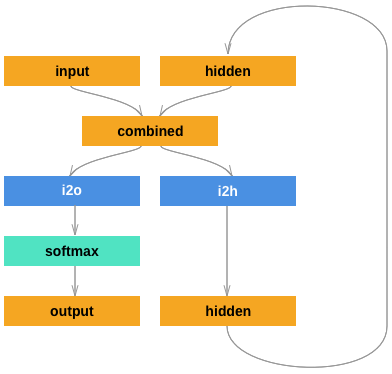

In [ ]:
from IPython.display import Image
Image('rnn.png')

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # hidden gate : hidden값 들어가는 gate
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # output gate : output값 나오는 gate 
        self.softmax = nn.LogSoftmax(dim=1) # output값에 사용

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
#Cell하나 통과할 때의 예시 
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output.shape)
print(next_hidden.shape)

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
#Cell하나 통과할 때의 예시 
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(output.shape)
print(next_hidden.shape)

tensor([[-2.9092, -2.8941, -2.7871, -2.8337, -3.0226, -2.9702, -2.9092, -2.7817,
         -2.8776, -2.9360, -2.9522, -2.8962, -2.8543, -2.8823, -2.9492, -2.9234,
         -2.8864, -2.7970]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 18])
torch.Size([1, 128])


## 학습
### 학습 준비

In [ ]:
# 네트워크 출력으로 가장 확률 이 높은 카테고리 이름(언어)와 카테고리 번호 반환
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 7)


In [ ]:
# 학습 예시를 가져오는 함수
# 하나의 이름과 이름의 언어를 가져옴
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor # line : 성 , category_tensor : 

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Gianakopulos
category = Russian / line = Dobroslavin
category = Chinese / line = Yim
category = Chinese / line = Zeng
category = Polish / line = Mencher
category = Japanese / line = Baba
category = Dutch / line = Maas
category = Czech / line = Stedronsky
category = Japanese / line = Hiranuma
category = Spanish / line = Escamilla


### 네트워크 학습
- RNN의 마지막 층이 `nn.LogSoftmax`이므로 `nn.NLLLoss`를 사용
(`nn.CrossEntropyLoss = nn.LogSoftmax + nn.NLLLoss`)
- 학습 루프


> 1. 입력과 정답 Tensor 생성
> 2. 0으로 초기화된 은닉 상태 생성
> 3. 각 문자를 읽기 & 다음 문자를 위한 은닉 상태 유지
> 4. 목표와 최종 출력 비교
> 5. 역전파
> 6. 출력과 손실 반환



In [ ]:
criterion = nn.NLLLoss().cuda()
learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.cuda()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().cuda() # hidden 초기화

    rnn.zero_grad() 

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].cuda(), hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000 # step 수 
print_every = 5000 #5000step마다 print
plot_every = 1000 #1000step마다 plot 



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor.cuda(), line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.6049 Deeb / Korean ✗ (Arabic)
10000 10% (0m 27s) 1.2649 Lolos / Greek ✓
15000 15% (0m 41s) 3.1196 Lawa / Japanese ✗ (Czech)
20000 20% (0m 55s) 1.9093 Michalovicova / Greek ✗ (Czech)
25000 25% (1m 8s) 0.4623 Bouloukos / Greek ✓
30000 30% (1m 22s) 3.6239 Dale / Irish ✗ (Dutch)
35000 35% (1m 36s) 2.4732 Awdeichikoff / Polish ✗ (Russian)
40000 40% (1m 50s) 1.2944 Iniguez / Spanish ✓
45000 45% (2m 3s) 2.8167 Althuis / Greek ✗ (Dutch)
50000 50% (2m 17s) 0.1215 Wilson / Scottish ✓
55000 55% (2m 31s) 2.5018 Pinho / Korean ✗ (Portuguese)
60000 60% (2m 45s) 1.5027 Bengochea / Czech ✗ (Spanish)
65000 65% (2m 58s) 3.2760 Manus / Arabic ✗ (Irish)
70000 70% (3m 12s) 4.2361 Oborny / Irish ✗ (Czech)
75000 75% (3m 26s) 0.0297 Patrianakos / Greek ✓
80000 80% (3m 39s) 0.5332 Wawrzaszek / Polish ✓
85000 85% (3m 53s) 2.4295 Rojas / Portuguese ✗ (Spanish)
90000 90% (4m 7s) 1.5456 Kumiega / Japanese ✗ (Polish)
95000 95% (4m 20s) 1.7266 Porras / Greek ✗ (Spanish)
100000 100% (4m 34s) 0.0235

### 결과 도식화
- `all_losses`를 이용해서 네트워크의 학습 과정을 도식화합니다

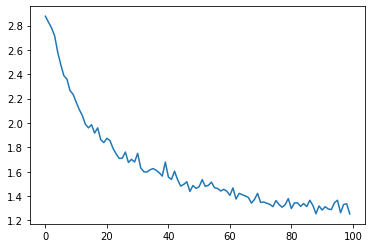

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 결과 평가
- 네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기위해서 모든 실제 언어가 네트워크에서 어떤 언어로 추출되는지를 나타내는 혼란 행렬(confusion matrix)를 만듭니다.
- 주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시할 수 있습니다.

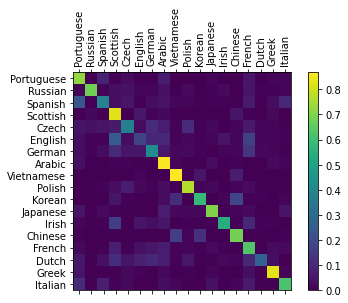

In [ ]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden().cuda()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].cuda(), hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky') # 가장 높은 score값 , 가장 높은 score값의 index 
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.40) Russian
(-1.35) Czech
(-3.88) English

> Jackson
(-0.09) Scottish
(-3.39) English
(-3.50) Russian

> Satoshi
(-1.07) Italian
(-1.32) Arabic
(-1.92) Japanese


# LSTM

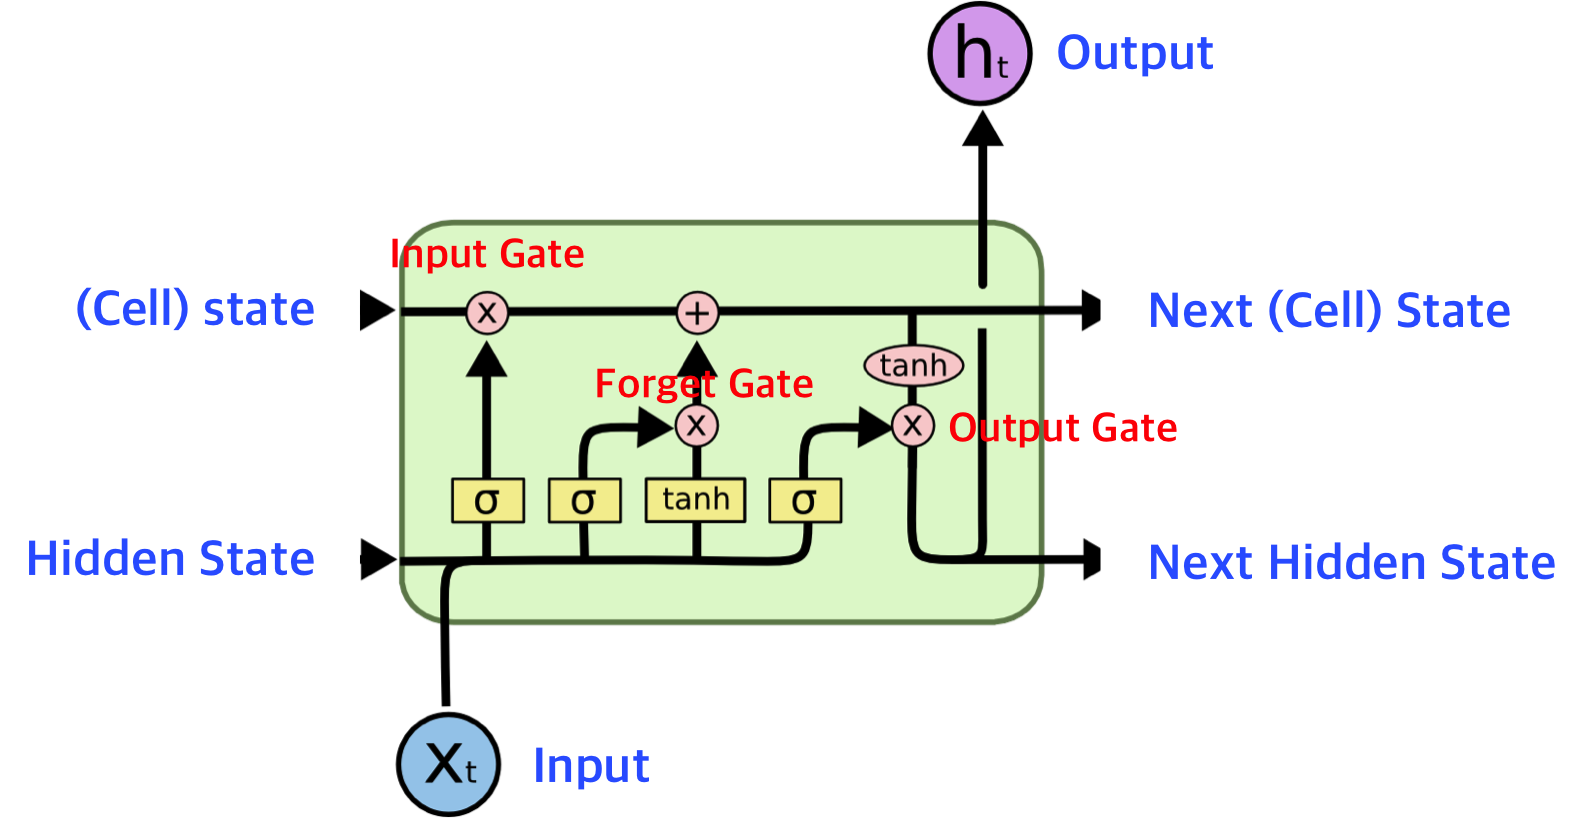

In [ ]:
from IPython.display import Image
Image('lstm.png')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

## 데이터 셋
`seaborn` 패키지에서 flights 데이터를 사용 \\
1949년~1960년까지의 승객 수 데이터를 포함

In [ ]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


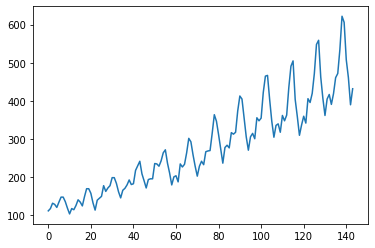

In [ ]:
 # 데이터 가시화 결과
 plt.plot(df['passengers'])

## 데이터 전처리

In [ ]:
# data split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df['passengers'].values.astype(float), test_size=0.2, shuffle=False)

In [ ]:
# normalizing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
transformed_train = scaler.fit_transform(train.reshape(-1, 1))
transformed_test = scaler.transform(test.reshape(-1, 1))

In [ ]:
sequence_length = 6 # monthly
def make_batch(input_data, sl):
    train_x = []
    train_y = []
    L = len(input_data)
    for i in range(L-sl):
        train_seq = input_data[i:i+sl]
        train_label = input_data[i+sl:i+sl+1]
        train_x.append(train_seq)
        train_y.append(train_label)
    return torch.Tensor(train_x), torch.Tensor(train_y)

In [ ]:
X_train, y_train = make_batch(transformed_train, sequence_length)
print('X_train size: ', X_train.size(), 'y_train size: ', y_train.size())

X_test, y_test = make_batch(transformed_test, sequence_length)
print('X_test size:', X_test.size(), 'y_test size: ', y_test.size())

X_train size:  torch.Size([109, 6, 1]) y_train size:  torch.Size([109, 1, 1])
X_test size: torch.Size([23, 6, 1]) y_test size:  torch.Size([23, 1, 1])


In [ ]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=32)

## 모델 & 학습

In [ ]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_dim, 64),
            nn.Linear(64,32),
            nn.Linear(32,1)
        )
        
    def forward(self, x):
        output, _ = self.lstm(x) #(hidden, cell) 데이터는 사용하지 않음
        return self.linear(output[:,-1,:])

In [ ]:
model = Model(input_dim=1, hidden_dim=128, output_dim=1, num_layers=2).cuda()
print(model)

Model(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss().cuda()
epochs = 500

In [ ]:
for i in range(epochs):
    model.train()
    
    for data, target in train_loader:
      optimizer.zero_grad()
      data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target.view(-1,1))
    
      loss.backward()
      optimizer.step()

    if i%25 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 0.39994
Epoch 25, Loss 0.04266
Epoch 50, Loss 0.02878
Epoch 75, Loss 0.01508
Epoch 100, Loss 0.00865
Epoch 125, Loss 0.00733
Epoch 150, Loss 0.00781
Epoch 175, Loss 0.00709
Epoch 200, Loss 0.00703
Epoch 225, Loss 0.00694
Epoch 250, Loss 0.00680
Epoch 275, Loss 0.00648
Epoch 300, Loss 0.00647
Epoch 325, Loss 0.00567
Epoch 350, Loss 0.00569
Epoch 375, Loss 0.00389
Epoch 400, Loss 0.00357
Epoch 425, Loss 0.00251
Epoch 450, Loss 0.00211
Epoch 475, Loss 0.00152


## 평가

In [ ]:
model.eval()
with torch.no_grad():
  predict = model(X_test.reshape(-1, 6, 1).cuda())
predict = predict.data.cpu().numpy()
actual_predictions = scaler.inverse_transform(predict)

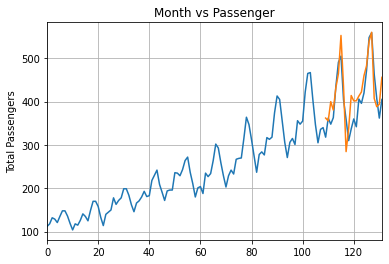

In [ ]:
x = np.arange(132-23,132,1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['passengers'][0:132])
plt.plot(x,actual_predictions.reshape(-1, ))
plt.show()